In [1]:
"""
Processing MSA
Script adapted from scaProcessMSA script by Olivier Rivoire, Kimberly Reynolds, and Rama Ranganathan described in “Evolution-Based Functional Decomposition of Proteins”
available at: http://reynoldsk.github.io/pySCA/
"""
from __future__ import division
import os
import numpy as np
import scipy.cluster.hierarchy as sch
import scaTools as sca #version of scaTools edited to work for RNA sequences
import math
import matplotlib

#define parameters
ref_index = 0 #index for reference sequence
max_frac_gaps_pos = 0.2 #maximum fraction of gaps allowed at a position
max_frac_gaps_seq = 0.2 #maximum fraction of gaps allowed in a sequence
min_sid = 0.2 #minimum sequence ID to ref sequence for weighting sequences
max_sid = 0.8 #maximum sequence ID to ref sequence for weighting sequences
lbda = 0.03 #lambda for pseudo-counting the alighment
n_seq = 2000
alignment_file = "inputs/CRW_no_gaps_BAEMC_truncation_removed_2800.fasta"
ref_pos_file = "inputs/23S_all_gi.txt" #filename of file contianing numbering of bases for refence sequence

#read and process alignment
headers_full, sequences_full = sca.readAlg(alignment_file)
print('Loaded alignment of %i sequences, %i positions.' % (len(headers_full), len(sequences_full[0])))
print("Trimming alignment for highly gapped positions (80% or more).")
s_tmp = sequences_full[ref_index]
f = open( ref_pos_file,'r')
ats_tmp = [line.rstrip('\n') for line in f]
f.close()
sequences, ats = sca.makeATS(sequences_full, ats_tmp, s_tmp, ref_index, False)
alg_out,poskeep = sca.filterPos(sequences_full,[1],.8)
sequences_full = alg_out
sequences = sequences_full
ats = [ats[i] for i in poskeep]
print("Alignment size post-trimming: %i positions" % len(sequences_full[0]))

print("Conducting sequence and position filtering: alignment size is %i seqs, %i pos" % (len(sequences), len(sequences[0])))
alg0, seqw0, seqkeep = sca.filterSeq(sequences, ref_index, max_fracgaps=max_frac_gaps_seq, min_seqid=min_sid, \
                                                                   max_seqid=max_sid)
headers = [headers_full[s] for s in seqkeep]
alg1, iposkeep = sca.filterPos(alg0, seqw0, max_frac_gaps_pos)
ats = [ats[i] for i in iposkeep]
alg = alg1
hd = headers

#convert alignment to numerical form
seqw = sca.seqWeights(alg,max_seqid=max_sid)
effseqs = seqw.sum()
msa_num = sca.lett2num(alg)
Nseq, Npos = msa_num.shape
print("Final alignment parameters:")
print("Number of sequences: M = %i" % (Nseq))
print("Number of effective sequences: M' = %f" % math.floor(effseqs))
print("Number of alignment positions: L = %i" % (Npos))


Loaded alignment of 2483 sequences, 2904 positions.
Trimming alignment for highly gapped positions (80% or more).
len ref sequence:
2904
Alignment size post-trimming: 2904 positions
Conducting sequence and position filtering: alignment size is 2483 seqs, 2904 pos
Final alignment parameters:
Number of sequences: M = 2464
Number of effective sequences: M' = 80.000000
Number of alignment positions: L = 2798


In [13]:
"""
Calculating coupling matrix
Script adapted from scaCore script by Olivier Rivoire, Kimberly Reynolds, and Rama Ranganathan described in “Evolution-Based Functional Decomposition of Proteins”
available at: http://reynoldsk.github.io/pySCA/
"""
from __future__ import division
import os
import numpy as np
import scipy.cluster.hierarchy as sch
import scaTools as sca #version of scaTools edited to work for RNA sequences
import math
import matplotlib


#set parameters
Ntrials = 10 #number of random matrices to generate
norm = 'frob' #type of matrix norm for reducing dimensions frob=frobenius norm

#calculate coupling matrix
print("Computing the sequence projections.")
Useq, Uica = sca.seqProj(msa_num, seqw, kseq = 30, kica = 15)
simMat = sca.seqSim(msa_num)

print("Computing the SCA conservation and correlation values.")
Wia,Dia,Di = sca.posWeights(msa_num, seqw, lbda)
freq1, freq2, freq0 = sca.freq(msa_num, seqw, 4, lbda, freq0 = np.array([.2706, .306, .207, .217]))
Csca, tX, Proj = sca.scaMat(msa_num, seqw, norm, lbda)

print("Running the matrix randomization...")
Vrand, Lrand, Crand = sca.randomize(msa_num, 10, seqw, norm=norm,lbda=.0001)#lbda



Computing the sequence projections.
Computing the SCA conservation and correlation values.
Running the matrix randomization...
0
1
2
3
4
5
6
7
8
9


In [14]:
"""
Calculating ICs and sectors
Script adapted from scaSectorID script by Olivier Rivoire, Kimberly Reynolds, and Rama Ranganathan described in “Evolution-Based Functional Decomposition of Proteins”
available at: http://reynoldsk.github.io/pySCA/
"""
p_cutoff = .95 #percentile to assign position to IC

#calculate eigenmodes
Vsca, Lsca = sca.eigenVect(Csca)
kpos = sca.chooseKpos(Lsca,Lrand)
print("Selected kpos=%i significant eigenmodes." % kpos)
Vpica, Wpica = sca.rotICA(Vsca, kmax=kpos)
ics,icsize,sortedpos,cutoff,scaled_pd, pd = sca.icList(Vpica,kpos,Csca, p_cut=p_cutoff)
Usca = tX.dot(Vsca[:,:kpos]).dot(np.diag(1/np.sqrt(Lsca[:kpos])))
Upica = Wpica.dot(Usca.T).T
for k in range(Upica.shape[1]): Upica[:,k] /= np.sqrt(Upica[:,k].T.dot(Upica[:,k]))
Usica, Wsica = sca.rotICA(Usca, kmax=kpos)

Selected kpos=20 significant eigenmodes.
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [5]:
"""
Save results as python session
"""
import shelve
#results of sequence analysis
D_seq = {}
D_seq['alg'] = alg
D_seq['hd'] = hd
D_seq['msa_num'] = msa_num
D_seq['seqw'] = seqw
D_seq['Nseq'] = Nseq
D_seq['Npos'] = Npos
D_seq['ats'] = ats
D_seq['effseqs'] = effseqs
D_seq['limitseqs'] = n_seq
D_seq['refseq'] = ref_index
D_seq['refpos'] = ref_pos_file
D_seq['i_ref'] = ref_index

#coupling matrix calculation results
D_sca={}
D_sca['freq1'] = freq1
D_sca['Useq'] = Useq
D_sca['Uica'] = Uica
D_sca['lbda'] = lbda
D_sca['Wia'] = Wia
D_sca['Dia'] = Dia
D_sca['Di'] = Di
D_sca['Csca'] = Csca
D_sca['tX'] = tX
D_sca['Proj'] = Proj
D_sca['Ntrials']  = Ntrials
D_sca['Vrand'] = Vrand
D_sca['Lrand'] = Lrand

#IC and sector calculation results
D_sector={}
D_sector['Vsca'] = Vsca
D_sector['Lsca'] = Lsca
D_sector['Lrand'] = Lrand
D_sector['kpos'] = kpos
D_sector['Vpica'] = Vpica
D_sector['Wpica'] = Wpica
D_sector['Usca'] = Usca
D_sector['Upica'] = Upica
D_sector['Usica'] = Usica
D_sector['Wsica'] = Wsica
D_sector['ics'] = ics
D_sector['icsize'] = icsize
D_sector['sortedpos'] = sortedpos
D_sector['cutoff'] = p_cutoff
D_sector['vpica_cutoffs'] = cutoff
D_sector['scaled_pd'] = scaled_pd
D_sector['pd'] = pd
    
db = shelve.open("Outputs/sca_results")
db['sequence']=D_seq
db['sca']=D_sca
db['sector'] = D_sector
db.close()

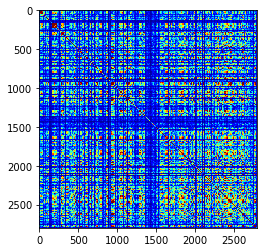

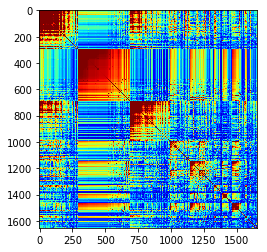

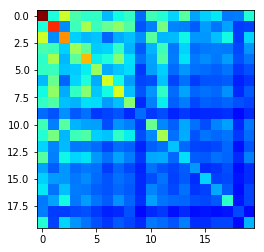

In [6]:
"""
Make images for Figure 1 (matrix images)
"""
#display coupling matrix
fig1, ax1 = matplotlib.pyplot.subplots()
ax1.imshow(Csca,vmin=0,vmax=.5,cmap="jet")

#display coupling matrix for top ten ICs
fig2, ax2 = matplotlib.pyplot.subplots()
index_of_top10_IC_end = 0
for x in icsize[0:10]: index_of_top10_IC_end=index_of_top10_IC_end+x
Csca_sorted = Csca[:,sortedpos[0:index_of_top10_IC_end]][sortedpos[0:index_of_top10_IC_end],:]
ax2.imshow(Csca_sorted,vmin=0,vmax=.5,cmap="jet")

#display matrix showing coupling between sectors
#calculate the average coupling between positions in sectors
avg_couplings = []
i=0
for s1 in ics:
    j = 0
    avg_couplings.append([])
    for s2 in ics:
        #if j <i:
         #   j+=1
          #  continue
        avg_coupling = 0.0
        total_pairs = 0.0
        for p1 in s1.items:
            for p2 in s2.items:
                coupling = Csca[p1][p2]
                avg_coupling += coupling
                total_pairs += 1
        avg_couplings[i].append(avg_coupling/total_pairs)
        j += 1
    i+= 1
    
#display avg couplings matrix
fig3, ax3 = matplotlib.pyplot.subplots()
ax3.imshow(avg_couplings,vmin=0,vmax=.5,cmap="jet")

In [15]:
"""
Output pymol selections for ICs, write csv file for RiboVision, write ranked list of Sector positions
"""
#write file with pymol selection commands
ic_num = 1
outfile = open("Outputs/ic_pymol_selection.txt",'w')
large_subunit_object_name = "23S" #name of object with 23S or chain containing 23S
for ic in ics:
    outfile.write("sele IC" + str(ic_num) +", 23S and (")
    count = 0
    for i in ic.items:
        sequence_index = ats[i]
        if count > 0:
            outfile.write(" + resi " + sequence_index)
        else:
            outfile.write("resi " + sequence_index)
        count += 1
    outfile.write(")\n")
    ic_num += 1
outfile.close()

#write file to color RiboVision image
template_file = open("EC_LSU_3D_UserDataTemplate.csv", 'r')
LSU_data = []
fiveS_data = []
for line in template_file:
    if "23S" in line:
        LSU_data.append(line)
    if "5S" in line:
        fiveS_data.append(line)
template_file.close()

outfile = open('outputs/ribovision_colored.csv', 'w')
outfile.write("resNum,resName,ColorCol,DataDescription\n")
for i in range(1, 2905):
    outfile.write("23S:" + str(i) + ",")
    outfile.write(LSU_data[i-1].split(",")[1]+",")
    final_ic_num = 0
    ic_num = 1
    for ic in ics:
        for pos in ic.items:
            sequence_index = ats[pos]
            if str(i) == str(sequence_index):
                final_ic_num = ic_num
                break
        ic_num += 1
    if final_ic_num == 1:
        outfile.write("#337FCC\n")
    elif final_ic_num == 3:
        outfile.write("#00FFFF\n")
    elif final_ic_num == 2:
        outfile.write("#B24C66\n")
    elif final_ic_num == 5:
        outfile.write("#FF8C69\n")
    else:
        outfile.write("#858585\n")
for line in fiveS_data:
    outfile.write(line.split(",")[0]+","+line.split(",")[1]+",#858585\n")
outfile.close()

#write ranked list of positions in sectors
ics_in_sectors = [[0, 2], [1,4]]

ev_weights = [] #weights for averaging ics into sectors
for i in range(0, Vpica.shape[1]):
    ev= np.matmul(Vpica[:,i].T, np.matmul(Csca, Vpica[:,i]))
    ev_weights.append(ev)
i= 0
for s in ics_in_sectors:
    i += 1
    outfile = open("Outputs/ranked_positions_sector_"   + str(i) + ".txt", 'w')
    average_vector = np.zeros(Vpica[:,0].shape)
    total_weights = 0
    pos_in_sector = []
    for j in s:
        average_vector += ev_weights[j]*Vpica[:,j]
        total_weights += ev_weights[j]
        current_size = icsize[j]
        previous_sizes = int(np.sum(icsize[0:j]))
        pos_in_sector += sortedpos[previous_sizes:previous_sizes + current_size]
    average_vector /= total_weights
    average_vector = average_vector[sorted(pos_in_sector)]
    sorted_indices = np.argsort(-1*average_vector)
    for index in sorted_indices:
        outfile.write(ats[sorted(pos_in_sector)[index]] + ", " + str(average_vector[index]) +  "\n")
    outfile.close()


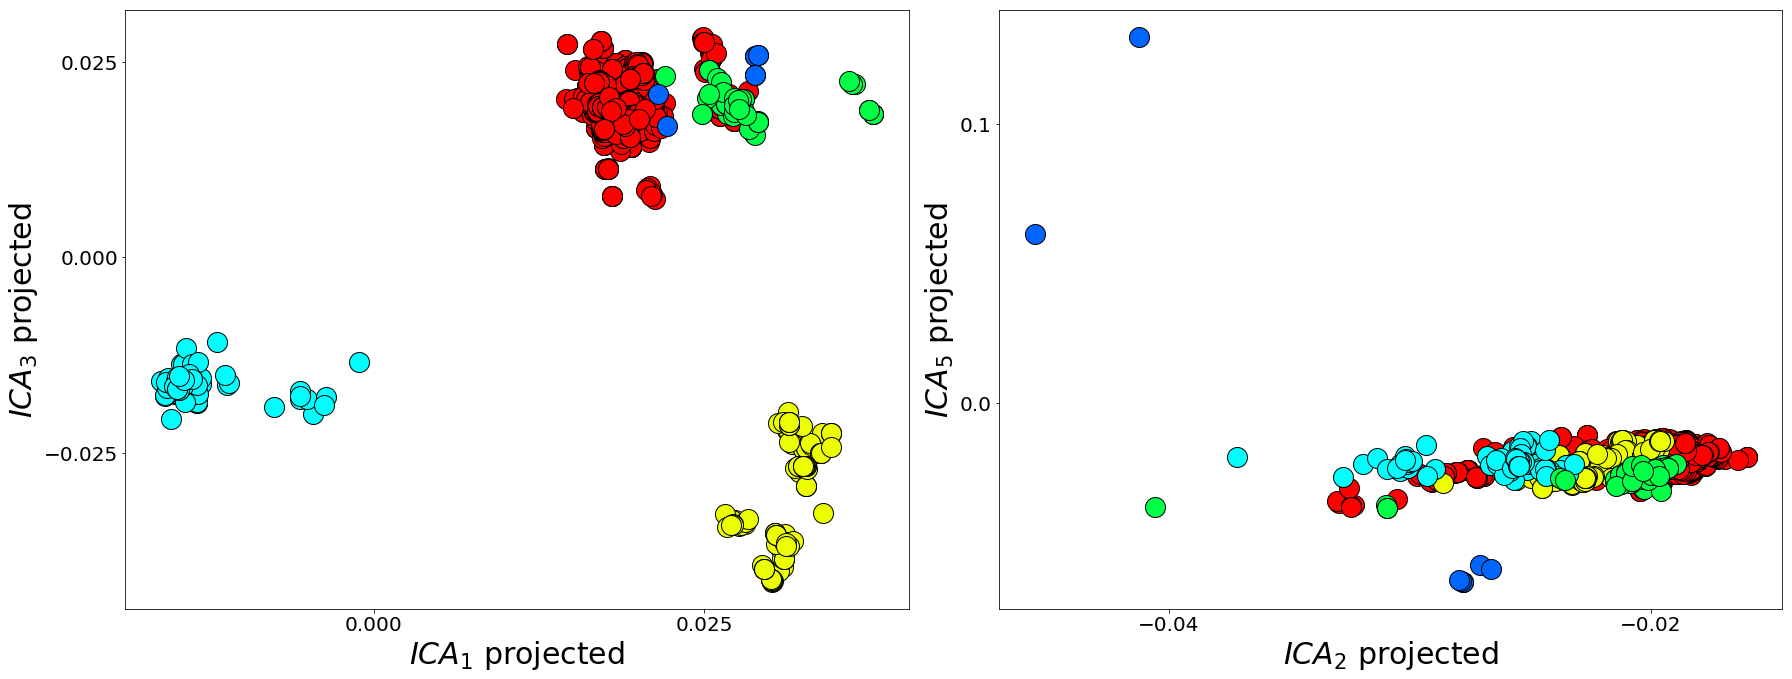

In [8]:
"""
Make images for Figure 7 (sequence projection of ICs)
Script adapted from script by Olivier Rivoire, Kimberly Reynolds, and Rama Ranganathan described in “Evolution-Based Functional Decomposition of Proteins”
available at: http://reynoldsk.github.io/pySCA/
"""
domains = ['B', 'A', 'E', 'C', 'M']
domain_classifications = {}
domain_classifications['B'] = ['Escherichia','Dictyoglomus','uncultured_Chloroflexi_bacterium','Dehalococcoides','Actinobacteria', 'Rubrobacter', 'Conexibacter','Actinobacteridae',
'Actinomycetales','Arcanobacterium','Corynebacterineae','Tsukamurella','Gordonia','Williamsia','Corynebacteriaceae','Corynebacterium','Mycobacterium','Nocardiaceae','Nocardia','Rhodococcus','Frankineae',
'Acidothermus','Frankia','Cellulomonadaceae','Tropheryma','Oerskovia','Microbacteriaceae','actinobacterium','Microbacterium','Leifsonia','Clavibacter','Micrococcaceae','Micrococcus',
'Renibacterium','Kocuria','Arthrobacter','Micromonosporineae','Actinoplanes','Micromonospora','Propionibacterineae','Propionibacterium','Kribbella','Pseudonocardineae', 'Actinosynnemataceae',
'Actinosynnema','Amycolatopsis','Saccharopolyspora','Pseudonocardia','Saccharomonospora','Thermobispora','Streptomycineae','Streptomycetaceae','Streptomycoides','Trichotomospora',
'Streptomyces','Streptosporangineae','Nocardiopsaceae','Thermobifida','Streptosporangiaceae','Microtetraspora','Streptosporangium','Microbispora','Nonomuraea','Nonomuria',
'Thermomonosporaceae','Spirillospora','Actinocorallia','Actinomadura','Thermomonospora','uncultured_actinomycete','Bifidobacteriales','Bifidobacterium','Actinobacteria',
'Symbiobacterium','actinobacterium','Aquificae','Aquifex','Bacteroidetes','Cytophaga','Flexibacter','Salinibacter','Cytophagales','Bacteroidales','Bacteroides','Porphyromonas',
'Flavobacteria','Flavobacteriales','Blattabacteriaceae','Blattabacterium','Flavobacteriaceae','Gramella','Myroides','Riemerella','Chlorobi','Chlorobium','Pelodictyon',
'Chlamydiae','Chlamydiales','Fritschea','Simkania','Waddlia','Chlamydiaceae','Criblamydia','Chlamydia','Chlamydophila','Parachlamydia','Verrucomicrobium',
'Prosthecobacter','Cyanobacteria','cyanobacterium','Acaryochloris','Chroococcales','Aphanothece','Synechocystis','Gloeothece','Cyanothece','Euhalothece',
'Thermosynechococcus','Microcystis','Synechococcus','Gloeobacteria','Nostocales','Tolypothrix','Nostocaceae','Aphanizomenon','Nodularia','Mojavia','Anabaena','Nostoc',
'Oscillatoriales','Trichodesmium','Spirulina','Lyngbya','Plectonema','Microcoleus','Planktothrix','Geitlerinema','Limnothrix','Trichodesmium','Arthrospira',
'Leptolyngbya','Oscillatoria','Prochlorales','Prochlorococcaceae','Prochlorococcus','Deinococcales','Deinococcus','Thermus','Fibrobacteres','Fibrobacter','uncultured_bacterium',
'Acidobacteria','Solibacter','Holophaga','Geothrix','Bacilli','Bacillales','Sporosarcina','Pasteuria','Bacillaceae','Bacillus','Listeria','Paenibacillus','Sporolactobacillus',
'Tuberibacillus','Staphylococcus','Enterococcaceae','Melissococcus','Tetragenococcus','Enterococcus','Lactobacillus','Pediococcus','Leuconostocaceae','Leuconostoc','Oenococcus',
'Weissella','Lactococcus','Anabaena','Nodularia','Plectonema','Microcoleus','Trichodesmium','Leptolyngbya','Oscillatoria','Prochlorococcus','Clostridium','Desulfitobacterium','Mycoplasma','Magnetococcus',
'Caulobacter','Phenylobacterium','Caulobacteraceae','Bartonella','Brucella','Agrobacterium','Paracoccus','Sinorhizobium','Maricaulis','Rhizobium','Roseobacter',
'Acidiphilium','Asaia','Neoasaia','Gluconacetobacter','Rhodospirillum','Magnetospirillum','Anaplasma','Ehrlichia','Neorickettsia','Rickettsia','Wolbachia','Novosphingobium',
'Sphingopyxis','Zymomonas','proteobacterium','Nitrosomonas','Thiobacillus','Methylobacillus','Candidatus','Acidovorax','Polaromonas','Rhodoferax','Taylorella', 'Alcaligenes',
'Bordetella','Burkholderia','Ralstonia','Collimonas','Herbaspirillum','Thiomonas','Chromobacterium','Neisseria','Azoarcus','Dechloromonas','Halorhodospira','Alkalilimnicola','Nitrosococcus',
'Methylococcus','Acidithiobacillus','Aeromonas','Saccharophagus','Psychromonas','Marinobacter','Colwellia','Idiomarina','Pseudoalteromonas','Shewanella','Morganella','Arsenophonus',
'Buchnera','Klebsiella','Erwinia','Photorhabdus','Salmonella','Shigella','Sodalis','Wigglesworthia','Yersinia','secondary_symbiont','secondary_endosymbiont','primary_endosymbiont','Legionella',
'Alcanivorax','Hahella','Chromohalobacter','Halomonas','Actinobacillus','Haemophilus','Mannheimia','Acinetobacter','Psychrobacter','Pseudomonas','Francisella','Thiomicrospira','Photobacterium',
'Vibrio','Xanthomonas','Xylella','proteobacterium','Baumannia','Carsonella','Desulfotalea','Desulfovibrio','Pelobacter','Geobacter','Myxococcus','Anaeromyxobacter','Stigmatella','Campylobacter',
'Helicobacter','Thiomicrospira','Brachyspira','Leptospira','Borrelia','Treponema','Thermosipho','Fervidobacterium','Petrotoga','Marinitoga','Thermotoga','uncultured_bacterium']
domain_classifications['A'] = ['Cenarchaeum','Hyperthermus', 'Desulfurococcus','Staphylothermus','Aeropyrum','Acidianus','Stygiolobus','Metallosphaera','Sulfolobus','Thermofilum','Pyrobaculum','Thermoproteus',
'planktonic','Archaeoglobus','marine_crenarchaeote','Archaeoglobus','archaeon','planktonic_euryarchaeote','euryarchaeote','Halobacteria','Halobacteriales','Halobacteriaceae','Halobacterium',
'Halococcus','Natrialba','Natronomonas','Haloferax','Haloquadratum','Haloarcula','Halosimplex','Natrinema','Methanothermobacter','Methanobacterium','Methanococci','Methanococcus','Methanomicrobiales',
'Methanospirillum','Methanocorpusculum','Methanoculleus','Methanosaeta','Methanococcoides','Methanosarcina','Thermococcales','Palaeococcus','Pyrococcus','Thermococcus','Thermoplasma']
domain_classifications['E'] = ['Saccharomyces','Eimeria','00004::Toxoplasma','00005::Toxoplasma','00006::Toxoplasma_gondii','00008::Plasmodium_falciparum','Theileria','00015::Tetrahymena_thermophila',
'00016::Euplotes_aediculatus','00017::Prorocentrum_micans','00018::Chlorarachnion_CCMP621','00019::Guillardia_theta','00020::Guillardia_theta','00021::Guillardia_theta','00022::Giardia_ardeae',
'00023::Giardia_intestinalis','00024::Giardia_muris','00025::Entamoeba_histolytica','00026::Euglena_gracilis','00027::Crithidia_fasciculata','Trypanosoma',
'00030::Metarhizium','00031::Pyricularia','00032::Arxula_adeninivorans','00033::Eremothecium_gossypii','00038::Candida_albicans', '00039::Candida_albicans:', '00040::Pneumocystis','00041::Schizosaccharomyces','00042::Schizosaccharomyces',
'00043::Filobasidiella_','00044::Filobasidiella','00045::Tricholoma','00046::Blastocladiella','00047::Entomophaga','00048::Mucor','00049::Rhizomucor','00050::Dugesia','00051::Eptatretus','00052::Hydrolagus',
'00054::Anguilla','00055::Oncorhynchus','00056::Latimeria','00057::Neoceratodus','00058::Lepidosiren','00059::Protopterus','00060::Homo_sapiens','00061::Homo_sapiens','00062::Mus_musculus','00063::Rattus',
'00064::Xenopus','00065::Xenopus','00067::Xenopus','00068::Petromyzon','00069::Herdmania','00070::Drosophila','00071::Drosophila','00072::Chironomus','00073::Anopheles','00074::Aedes',
'00075::Caenorhabditis','00081::Dictyostelium','00082::Didymium','00083::Physarum','00084::Chlorella','00085::Funaria','00086::Marchantia','0087::Ephedra','00088::Gnetum','00089::Acorus',
'00090::Oryza','00091::Drimys','00092::Lycopersicon','00093::Tragopogon','00094::Plumbago','00095::Eucryphia','00096::Fragaria','00097::Parnassia','00098::Arabidopsis','00099::Arabidopsis',
'00100::Brassica','00101::Sinapis','00102::Sinapis','00103::Citrus','00104::Hamamelis']
domain_classifications['C'] = ['Chloroplast','00006::Chlorarachnion','00007::Emiliania_huxleyi','00008::Emiliania_huxleyi','00009::Guillardia_theta','00010::Guillardia_theta','00011::Teleaulax_amphioxeia',
'00012::Cyanophora_paradoxa','00013::uncultured_phototrophic_eukaryote','00014::Paulinella_chromatophora','00015::_2__Alveolata','00024::Atoxoplasma','Chloroplast','00032::Hammondia_heydorni','00040::Plasmodium_sp',
'00041::Plasmodium_sp','00043::plastid_like_Plasmodium_falciparum','00029::Toxoplasma','00030::Toxoplasma','00044::Plasmodium','Plastid','00063::Euglena','00064::Euglena','00065::Euglena','00066::Euglena',
'00067::Euglena','00070::Gracilaria','00071::Porphyra','00074::Porphyra','00075::Porphyra','00076::Porphyra','00077::Compsopogon','00078::Cyanidium','00083::Oltmannsiellopsis','00088::Parietochloris',"00089::Stigeoclonium",
'00090::Stigeoclonium','00092::Chlorosarcina','00096::Haematococcus','00098::Chlorogonium','00110::Carteria','Chlamydomonas_iyengarii','00120::Chlamydomonas','00121::Chlamydomonas','00122::Chlamydomonas',
'00123::Chlamydomonas','00124::Chlamydomonas','00125::Chlamydomonas',
'00145::Pediastrum','00146::Ankistrodesmus','00147::Neochloris','00150::Pedinomonas','00151::Scourfieldia','00155::Monomastix','00156::Monomastix','00157::Tetraselmis','00158::Scherffelia',
'00159::Scherffelia','00160::Pyramimonas','00162::Pterosperma','00166::Pseudoscourfieldia','00172::Prototheca','00176::Microthamnion','00179::Chlorella','00183::Pseudendoclonium','00184::Gloeotilopsis',
'00186::Chamaetrichon','00190::Mesostigma','00193::Klebsormidium','00194::Spirogyra','00195::Coleochaete','00196::Chara','00198::Sphaerocarpos','00199::Monoclea','00200::Targionia','00201::Reboulia',
'00202::Conocephalum','00203::Ricciocarpos','00204::Riccia','00206::Blepharostoma','00207::Ptilidium','00208::Lepicolea','00209::Trichocolea','00210::Lepidogyna','00211::Lepidozia','00212::Bazzania',
'00213::Calypogeia','00214::Lophozia','00215::Solenostoma','00216::Marsupella','00217::Scapania','00218::Schistochila','00219::Lophocolea','00220::Plagiochila','00221::Tylimanthus','00222::Porella',
'00223::Frullania','00224::Lejeunea','00225::Leucolejeunea','00226::Treubia','00227::Fossombronia','00228::Blasia','00229::Pellia','00230::Pallavicinia','00231::Hymenophyton','00232::Metzgeria',
'00233::Sphagnum','00234::Sphagnum','00235::Archidium','00236::Buxbaumia','00237::Atrichum','00239::Tetraphis','00240::Bryoxiphium','00241::Ceratodon','00242::Dicranum','00243::Hymenostylium',
'00244::Grimmia','00245::Physcomitrella','00247::Mnium','00248::Leptobryum','00249::Bartramia','00250::Rhizogonium','00251::Ptychomitrium','00252::Orthotrichum','00253::Hedwigia',
'00254::Leucodon','00255::Fontinalis','0256::Thamnobryum','00257::Weymouthia','00258::Hookeria','00259::Anomodon','00260::Thuidium','00261::Brachythecium','00262::Hypnum','00263::Heterophyllium',
'00264::Hylocomium','00265::Climacium','00266::Plagiothecium','00267::Myurium','00269::Takakia','00271::Phaeoceros','00272::Dendroceros','00274::Notothylas','00275::Lycopodium','00276::Isoetes',
'00277::Equisetum','00278::Psilotum','00279::Tmesipteris','00280::Botrychium','00281::Helminthostachys','00282::Ophioglossum','00283::Angiopteris','00284::Marattia','00285::Danaea','00286::Leptopteris',
'00287::Osmunda','00288::Todea','00290::Gleichenia','00291::Lygodium','00292::Anemia','00293::Stangeria','00294::Zamia','00295::Ginkgo','00296::Araucaria','00297::Podocarpus','00298::Sciadopitys',
'00299::Cedrus','00300::Abies','00301::Ephedra','00302::Amborella','00303::Nymphaea','00304::Cabomba','00305::Schisandra','00306::Austrobaileya','00307::Ceratophyllum','00308::Acorus',
'00309::Tofieldia','00310::Spathiphyllum','00311::Alisma','00312::Dioscorea','00313::Croomia','00314::Canella','00317::Myristica','00318::Calycanthus','00319::Cinnamomum','00320::Ranunculus',
'00321::Dicentra','00322::Platanus','00323::Sabia','00324::Buxus','00326::Corsinia','00331::Klebsormidium','00335::Chara','00336::Chara','00337::Chara']
domain_classifications['M'] = ['Mitochondria']

color = (0, 0.18, 0.5, 0.38, 0.6)
domain_phylo = list()
for i, k in enumerate(domains):
    sf = sca.Unit()
    sf.name = domains[i].lower()
    sf.col = color[i]
    sf.items = []
    for j,q in enumerate(headers):
        for name in domain_classifications[k]:
            if name in q:
                sf.items.append(j)
                break
    domain_phylo.append(sf)
    
matplotlib.pyplot.rcParams['figure.figsize'] = 25,18
#which ICs to plot
pairs = []
pairs.append([0,2])
pairs.append([1,4])
for k,[k1,k2] in enumerate(pairs):
    matplotlib.pyplot.locator_params(nbins=2)
    matplotlib.pyplot.subplot(2,2,k+1)
    sca.figUnits(Upica[:,k1], Upica[:,k2], domain_phylo,dotsize=20,notinunits=[0])
    matplotlib.pyplot.tick_params(axis='both', which='major', labelsize=20)
    matplotlib.pyplot.xlabel(r"${ICA}_{%i}$ projected"%(k1+1), fontsize=30)
    matplotlib.pyplot.ylabel(r"${ICA}_{%i}$ projected"%(k2+1), fontsize=30)
matplotlib.pyplot.locator_params(nbins=2)
matplotlib.pyplot.tight_layout()